* 깊은 학습
* 그리고 가벼움
* 간단한 갯수를 돌림

# 불러오기

In [1]:
import numpy as np
#import cv2
import matplotlib.image as mpimg
import os
from keras.utils import np_utils

num_classes = 10
dataset_dir = "../dataset(revision)"

def shuffle_data(data, label):
    idx = np.arange(len(data))
    np.random.shuffle(idx)
    
    shuffled_data = np.array(data)[np.array(idx)]
    shuffled_label = np.array(label)[np.array(idx)]
    
    return shuffled_data, shuffled_label, idx


def load_data(parent_dir, ext):
    filepath_list = []
    image_list = []
    label_list = []
    
    dirnames = os.listdir(parent_dir)
    for dirname in dirnames: # 하위 디렉토리 탐색
        subdirpath = os.path.join(parent_dir, dirname)
        if os.path.isdir(subdirpath): # 디렉토리인 경우
            filenames = os.listdir(subdirpath)
        
            for filename in filenames:
                filepath = os.path.join(subdirpath, filename)
            
                _ext = os.path.splitext(filepath)[-1] # 파일 확장자 확인
                if _ext == ext:
                    image = mpimg.imread(filepath)
                    if image is None:
                        continue
                    
                    image = image.astype(np.float32) / 255.
                    image = image.reshape(28, 28, 1)

                    image_list.append(image)
                    label_list.append(dirname)
                    filepath_list.append(filepath)
                    
    return image_list, label_list, filepath_list


# data 불러오기
image_list, label_list, filepath_list = load_data(dataset_dir, '.bmp')

# one-hot vector로 변환
label_list = np_utils.to_categorical(label_list, num_classes)


# dataset 분할
data_len = len(label_list)
train_size = int(0.7 * data_len)
valid_size = int(0.15 * data_len)
test_size = data_len - train_size - valid_size
print(data_len)
print(train_size, '+', valid_size, '+', test_size, '=', train_size+valid_size+test_size)


# data shuffling
shuffled_image_list, shuffled_label_list, shuffled_idx = shuffle_data(image_list, label_list)

# dataset 구축
x_train = shuffled_image_list[:train_size]
y_train = shuffled_label_list[:train_size]
x_valid = shuffled_image_list[train_size:data_len-test_size]
y_valid = shuffled_label_list[train_size:data_len-test_size]
x_test = shuffled_image_list[data_len-test_size:]
y_test = shuffled_label_list[data_len-test_size:]
shuffle_indices = shuffled_idx[data_len-test_size:] # 디버그용
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Using TensorFlow backend.


8596
6017 + 1289 + 1290 = 8596
(6017, 28, 28, 1)
(6017, 10)
(1290, 28, 28, 1)
(1290, 10)


# 학습

In [2]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.models import Sequential, save_model

model = Sequential()

model.add(Conv2D(filters= 16, kernel_size = (3,3), activation='relu', padding='same', input_shape= x_train.shape[1:]))
model.add(Conv2D(filters= 16, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size= (2, 2)))

model.add(Conv2D(filters= 16, kernel_size = (3,3), activation='relu', padding='same'))
model.add(Conv2D(filters= 16, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size= (2, 2)))

model.add(Conv2D(filters= 16, kernel_size = (3,3), activation='relu', padding='same'))
model.add(Conv2D(filters= 16, kernel_size = (3,3), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

# configure the model
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

# prints a summary representation of the model
model.summary()

# set tensorboard
from keras.callbacks import TensorBoard
tbCallback = TensorBoard(log_dir='./tensorboard/deepAndLight')
tbCallback.set_model(model)

# save the model
save_model(model, './logs/my_model_deepAndLight.hdf5')

# make parameters checkpoint
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath="./logs/weights.best_deepAndLight.hdf5", verbose=1, 
                               monitor='loss', save_best_only=True, mode='auto')

# # set early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


# train the model
model.fit(x_train, y_train,
                epochs=50,
                batch_size=256,
                shuffle=False, # previously shuffled
                validation_data=(x_valid, y_valid),
                callbacks = [tbCallback, checkpoint, early_stopping])

'''
learning is done at this point
'''
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          2320      
__________

# 검증

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          2320      
__________

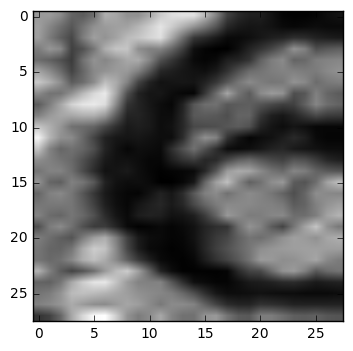

file: ../dataset(revision)\3\t_100A-1-V-20141030_170_00.bmp
1


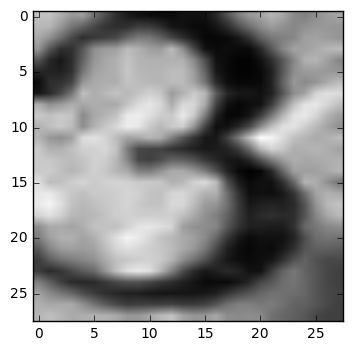

file: ../dataset(revision)\6\t_100A-1-V-20141030_143_03.bmp
5


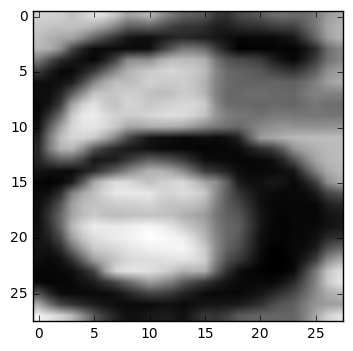

incorrect:  3 , total:  1290  accuracy:  0.9976744186046511


In [3]:
from keras.models import load_model

# restore trained model
loaded_model = load_model('./logs/my_model_deepAndLight.hdf5')
loaded_model.load_weights('./logs/weights.best_deepAndLight.hdf5')

# prints a summary representation of the model
loaded_model.summary()

# predict test data
predict = loaded_model.predict(x_test)

# show error cases
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cnt = 0
for i in range(test_size):
    if not (np.argmax(predict[i]) == np.argmax(y_test[i])):
        print('file: %s' % filepath_list[shuffle_indices[i]])
        print(np.argmax(predict[i]))
        cnt += 1

        img = mpimg.imread(filepath_list[shuffle_indices[i]])

        plt.gray()
        plt.imshow(img)
        plt.show()

print('incorrect: ', cnt, ', total: ', test_size, ' accuracy: ', (test_size-cnt)/test_size)